# Data exploratory
In this section, we do analysis on our soccer dataset from the league, team and player point of view, and make appropriate plots to get insight into it.

First, we load the data from the web.

In [1]:
import math
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
database = sql.connect("database.sqlite")
tables = pd.read_sql("Select * FROM sqlite_master WHERE type = 'table';", con=database)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [3]:
Teams = pd.read_sql("SELECT * FROM Team;", database)
teams = pd.read_sql("""SELECT team_api_id, team_long_name FROM Team;""", database)
Match = pd.read_sql("SELECT * FROM Match;", database)
match = pd.read_sql("""SELECT Match.country_id, Match.season, Match.home_team_api_id, Match.away_team_api_id, Match.home_team_goal, Match.away_team_goal
                        FROM Match;""", database)
Country = pd.read_sql("SELECT * from Country;", database)
Leagues = pd.read_sql("SELECT * FROM League;", database)
leagues = pd.read_sql("""SELECT Country.id as Country_id, Country.name as Country_name, League.name as League_name
                        FROM League
                        JOIN Country ON Country.id = League.country_id;""", database)

In [4]:
match = pd.merge(match, teams, left_on='home_team_api_id', right_on='team_api_id')
match = pd.merge(match, teams, left_on='away_team_api_id', right_on='team_api_id')
match = pd.merge(match, leagues, left_on='country_id', right_on='Country_id')

Define "goal_to_score" function to calculate the score of each team in one match with goal.\
The team with more goals wins, and the winner gets 3 points and loser gets 0 accordingly. If two teams have same goals, they both get 1 point.

In [5]:
def goal_to_score(a):
    if a > 0:
        return 3
    elif a == 0:
        return 1
    else:
        return 0

In [6]:
data = match.iloc[:, [1, 4, 5, 7, 9, 12]]
data['home_team_score'] = (data['home_team_goal']-data['away_team_goal']).map(goal_to_score)
data['away_team_score'] = (data['away_team_goal']-data['home_team_goal']).map(goal_to_score)
data['W'] = data['away_team_goal'] < data['home_team_goal']
data['D'] = data['away_team_goal'] == data['home_team_goal']
data['L'] = data['away_team_goal'] > data['home_team_goal']

Check if there's any missing data.

In [7]:
data.isnull().any()

season              False
home_team_goal      False
away_team_goal      False
team_long_name_x    False
team_long_name_y    False
League_name         False
home_team_score     False
away_team_score     False
W                   False
D                   False
L                   False
dtype: bool

No missing data

In [8]:
seasons = data['season'].unique().tolist()
leagues_list = leagues['League_name'].unique().tolist()
team_list = teams['team_long_name'].unique().tolist()

Create a dataframe to show the performance of each participating team along time.\
W: win, D: draw, L: lose, GF: goals for, GA: goals against, Pts: points, GD: goals difference.

In [9]:
group_1 = data.groupby(["season", "League_name", "team_long_name_x"]).agg('sum')
group_2 = data.groupby(["season", "League_name", "team_long_name_y"]).agg('sum')
group_list = list(group_2)
group_list[0], group_list[1], group_list[2], group_list[3], group_list[4], group_list[5], group_list[6] = group_list[1], group_list[0], group_list[3], group_list[2], group_list[6], group_list[5], group_list[4]
group_2.columns = group_list
Team_data_all = (group_1 + group_2).iloc[:, [2, 0, 1, 5, 3, 6]].astype(int)
Team_data_all.columns = ['W','D','L','GF','GA','Pts']
Team_data_all['GD'] = Team_data_all['GF'] - Team_data_all['GA']
Team_data_all

W   D   L  GF  \
season    League_name              team_long_name_x                          
2008/2009 Belgium Jupiler League   Beerschot AC             11   9  14  44   
                                   Club Brugge KV           18   5  11  59   
                                   FCV Dender EH             9   8  17  44   
                                   KAA Gent                 17   8   9  67   
                                   KRC Genk                 15   5  14  48   
...                                                         ..  ..  ..  ..   
2015/2016 Switzerland Super League FC Thun                  10  11  15  45   
                                   FC Vaduz                  7  15  14  44   
                                   FC Zürich                 7  13  16  48   
                                   Grasshopper Club Zürich  15   8  13  65   
                                   Lugano                    9   8  19  46   

                                                            GA  Pts  GD  
season    League_name              team_long_name_x                      
2008/2009 Belgium Jupiler League   Beerschot AC             42   42   2  
                                   Club Brugge KV           50   59   9  
                                   FCV Dender EH            58   35 -14  
                                   KAA Gent                 42   59  25  
                                   KRC Genk                 51   50  -3  
...                                                         ..  ...  ..  
2015/2016 Switzerland Super League FC Thun                  54   41  -9  
                                   FC Vaduz                 60   36 -16  
                                   FC Zürich                71   34 -23  
                                   Grasshopper Club Zürich  56   53   9  
                                   Lugano                   75   35 -29  

[1478 rows x 7 columns]

Number of participating teams of different leagues along time.

In [10]:
participating = data.groupby(["season", "League_name"]).agg('nunique')["team_long_name_x"]
participating

season     League_name             
2008/2009  Belgium Jupiler League      18
           England Premier League      20
           France Ligue 1              20
           Germany 1. Bundesliga       18
           Italy Serie A               20
                                       ..
2015/2016  Poland Ekstraklasa          16
           Portugal Liga ZON Sagres    18
           Scotland Premier League     12
           Spain LIGA BBVA             20
           Switzerland Super League    10
Name: team_long_name_x, Length: 88, dtype: int64

View the team ranking of a year in league (ascending by Pts)

In [11]:
Team_data_all.loc[(seasons[0], leagues_list[9])].sort_values(by='Pts', ascending=False, na_position='first').head()

,W,D,L,GF,GA,Pts,GD
team_long_name_x,,,,,,,
FC Barcelona,27,6,5,105,35,87,70
Real Madrid CF,25,3,10,83,52,78,31
Sevilla FC,21,7,10,54,39,70,15
Atlético Madrid,20,7,11,80,57,67,23
Villarreal CF,18,11,9,61,54,65,7


View the historical Pts of a team

In [12]:
Team_data_all.xs('Liverpool', level='team_long_name_x')

,,W,D,L,GF,GA,Pts,GD
season,League_name,,,,,,,
2008/2009,England Premier League,25,11,2,77,27,86,50
2009/2010,England Premier League,18,9,11,61,35,63,26
2010/2011,England Premier League,17,7,14,59,44,58,15
2011/2012,England Premier League,14,10,14,47,40,52,7
2012/2013,England Premier League,16,13,9,71,43,61,28
2013/2014,England Premier League,26,6,6,101,50,84,51
2014/2015,England Premier League,18,8,12,52,48,62,4
2015/2016,England Premier League,16,12,10,63,50,60,13


## From a historical point of view (by year)

Number of matches along time

In [13]:
match_number = match.groupby(match.season).count()
match_number['country_id']

season
2008/2009    3326
2009/2010    3230
2010/2011    3260
2011/2012    3220
2012/2013    3260
2013/2014    3032
2014/2015    3325
2015/2016    3326
Name: country_id, dtype: int64

Calculate the mean

In [14]:
match_number['country_id'].mean()

3247.375

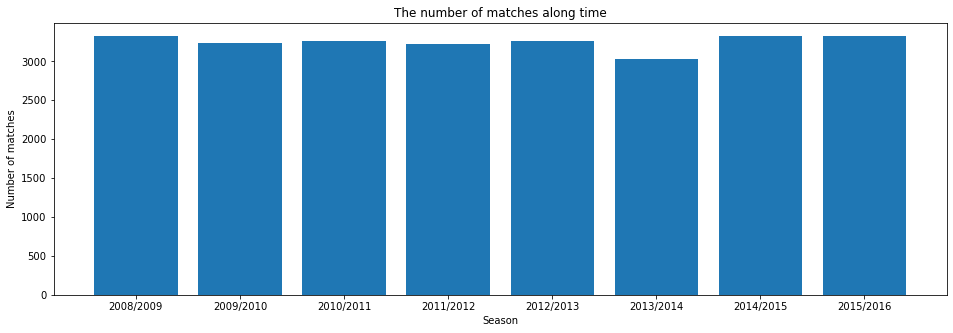

In [15]:
plt.subplots(figsize=(16,5))
plt.bar(match_number.index, match_number['country_id'])

plt.xlabel('Season')
plt.ylabel('Number of matches')
plt.title('The number of matches along time');

Number of participating teams along time

In [16]:
match_team_number = match.groupby(match.season).agg({'team_api_id_x':'nunique'})
match_team_number

,team_api_id_x
season,
2008/2009,188
2009/2010,185
2010/2011,186
2011/2012,186
2012/2013,186
2013/2014,174
2014/2015,188
2015/2016,188


Calculate the mean

In [17]:
match_team_number.mean()

team_api_id_x    185.125
dtype: float64

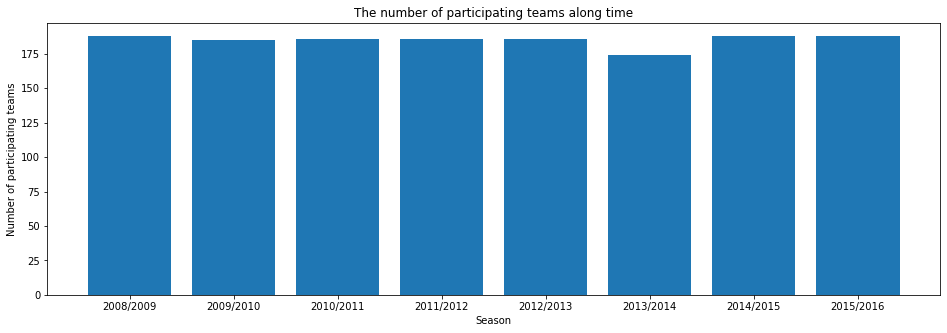

In [18]:
plt.subplots(figsize=(16,5))
plt.bar(match_team_number.index, match_team_number['team_api_id_x'])

plt.xlabel('Season')
plt.ylabel('Number of participating teams')
plt.title('The number of participating teams along time');

Thus the number of matches and total participating teams remains roughly constant over time, and the average is 3247 and 185 respectively.

Then we can see distribution of the times to participate in the season

In [19]:
league_team = data.groupby(['League_name','team_long_name_x']).agg('nunique')[['season','team_long_name_y']]
distribution_times = league_team.groupby('season').count()
distribution_times

,team_long_name_y
season,
1,51
2,24
3,27
4,29
5,21
6,23
7,29
8,92


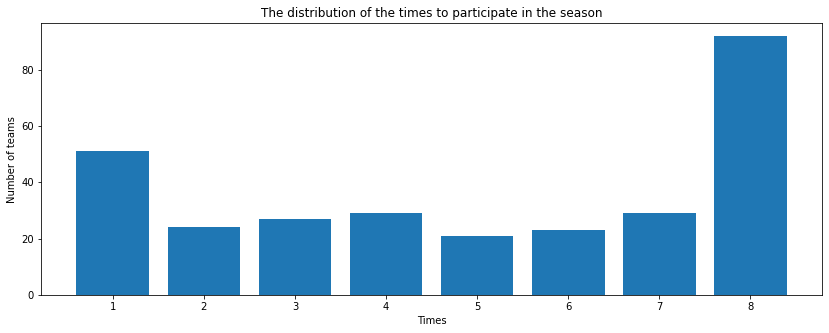

In [20]:
plt.subplots(figsize=(14,5))
plt.bar(distribution_times.index, distribution_times['team_long_name_y'])

plt.xlabel('Times')
plt.ylabel('Number of teams')
plt.title('The distribution of the times to participate in the season');

Acoording to the plot, 92 teams participated in all the seasons, and 51 teams participated only once, accounting for 31% and 17% of all teams respectively. Besides, the number of teams participating twice to seven times is similar, accounting for 8.6% of all teams in average.

Number of teams in each league

In [21]:
league_team_number = league_team.groupby('League_name').count()
league_team_number

,season,team_long_name_y
League_name,,
Belgium Jupiler League,24,24
England Premier League,34,34
France Ligue 1,35,35
Germany 1. Bundesliga,30,30
Italy Serie A,32,32
Netherlands Eredivisie,25,25
Poland Ekstraklasa,22,22
Portugal Liga ZON Sagres,29,29
Scotland Premier League,17,17


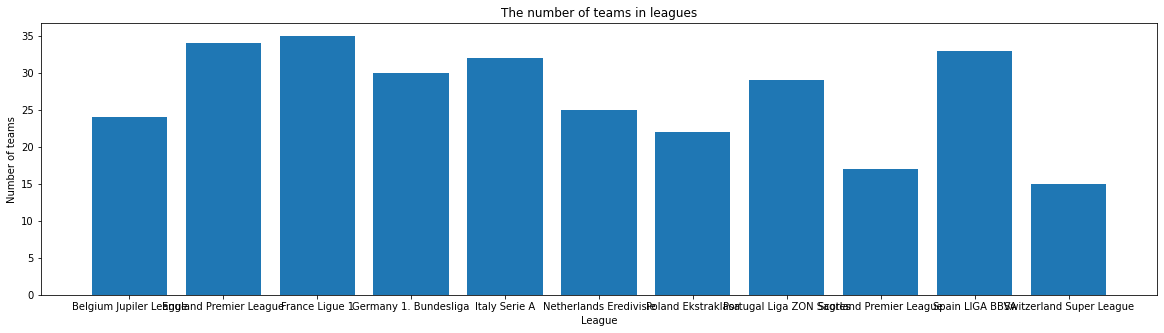

In [22]:
plt.subplots(figsize=(20,5))
plt.bar(league_team_number.index, league_team_number['season'])

plt.xlabel('League')
plt.ylabel('Number of teams')
plt.title('The number of teams in leagues');

Number of participating teams in each league along time

In [23]:
seasons #seasons not entirely sorted by year

['2008/2009',
 '2009/2010',
 '2010/2011',
 '2011/2012',
 '2012/2013',
 '2014/2015',
 '2015/2016',
 '2013/2014']

In [24]:
participating.loc[seasons[7]].index

Index(['Belgium Jupiler League', 'England Premier League', 'France Ligue 1',
       'Germany 1. Bundesliga', 'Italy Serie A', 'Netherlands Eredivisie',
       'Poland Ekstraklasa', 'Portugal Liga ZON Sagres',
       'Scotland Premier League', 'Spain LIGA BBVA',
       'Switzerland Super League'],
      dtype='object', name='League_name')

In [25]:
participating.loc[seasons[7]].values

array([ 4, 20, 20, 18, 20, 18, 16, 16, 12, 20, 10], dtype=int64)

Text(0, 0.6, 'Number of participating teams')

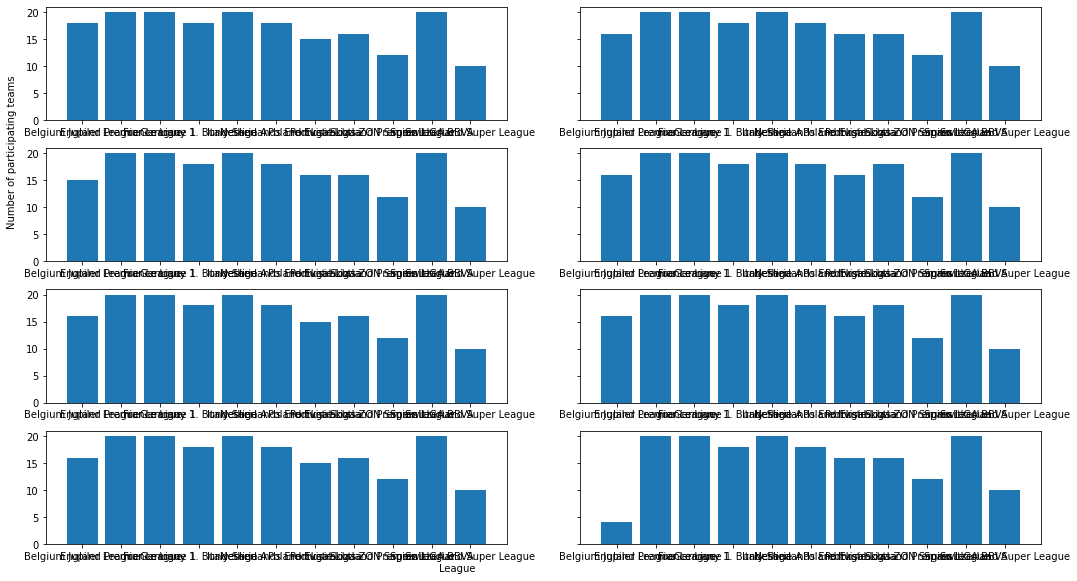

In [26]:
fig, ax = plt.subplots(4,2,figsize= (15,8), sharey = True)

for i in range(8):
    sbplt = ax[i%4, math.floor(i/4)]
    sbplt.bar(participating.loc[seasons[i]].index,participating.loc[seasons[i]].values)
    
fig.tight_layout()

fig.text(0.4,0, "League")
fig.text(0,0.6, "Number of participating teams", rotation = 90)

Ranking of teams by points in one season

In [27]:
Team_data_all.xs('2013/2014', level='season').sort_values(by='Pts', ascending=False, na_position='first')

W  D   L   GF  GA  Pts  GD
League_name             team_long_name_x                                
Italy Serie A           Juventus             33  3   2   80  23  102  57
Scotland Premier League Celtic               31  6   1  102  25   99  77
Germany 1. Bundesliga   FC Bayern Munich     29  3   2   94  23   90  71
Spain LIGA BBVA         Atlético Madrid      28  6   4   77  26   90  51
France Ligue 1          Paris Saint-Germain  27  8   3   84  23   89  61
...                                          .. ..  ..  ...  ..  ...  ..
Poland Ekstraklasa      Widzew Łódź           5  7  18   26  51   22 -25
Belgium Jupiler League  KV Oostende           4  2   0    7   1   14   6
                        KAA Gent              3  1   2   11   6   10   5
                        Lierse SK             2  0   4    5  12    6  -7
                        Waasland-Beveren      1  1   4    7  11    4  -4

[174 rows x 7 columns]

## From the team point of view

Let's look at the highest Pts team and lowest teams.

In [28]:
Team_data_all.sort_values(by='Pts', ascending=False, na_position='first')

,,,W,D,L,GF,GA,Pts,GD
season,League_name,team_long_name_x,,,,,,,
2013/2014,Italy Serie A,Juventus,33,3,2,80,23,102,57
2012/2013,Spain LIGA BBVA,FC Barcelona,32,4,2,115,40,100,75
2011/2012,Spain LIGA BBVA,Real Madrid CF,32,4,2,121,32,100,89
2013/2014,Scotland Premier League,Celtic,31,6,1,102,25,99,77
2009/2010,Spain LIGA BBVA,FC Barcelona,31,6,1,98,24,99,74
...,...,...,...,...,...,...,...,...,...
2013/2014,Belgium Jupiler League,KV Oostende,4,2,0,7,1,14,6
2012/2013,Belgium Jupiler League,KSV Cercle Brugge,3,5,22,30,65,14,-35
2013/2014,Belgium Jupiler League,KAA Gent,3,1,2,11,6,10,5


Juventus from Italy Serie A got 102 points in season 2013/2014, the highest points in history. And the teams which obtained the top five low points in history are all from Belgium Jupiler League.

Explore top 10 Pts teams along season.

In [29]:
for i in range(8):
    df = Team_data_all.loc[seasons[i]].sort_values(by='Pts', ascending=False, na_position='first').head(10)
    if i == 0:
        top_team = df
    else:
        top_team = pd.concat([top_team, df], axis=0)
        
top_team.groupby('team_long_name_x').count().sort_values(by='W', ascending=False, na_position='first').head()

,W,D,L,GF,GA,Pts,GD
team_long_name_x,,,,,,,
Celtic,8,8,8,8,8,8,8
FC Barcelona,8,8,8,8,8,8,8
Real Madrid CF,7,7,7,7,7,7,7
Paris Saint-Germain,5,5,5,5,5,5,5
Manchester United,5,5,5,5,5,5,5


Celtic and FC Barcelona are the only two teams that enter the top 10 points every season. And by observation, we can find FC Barcelona the team that won the most champions, which is four times in eight seasons.

How many teams participate the most and least matches?

In [30]:
# data_1 should have same statistics as data_2
# because each pair of teams change their role
# as for and against team
data_1 = data.groupby('team_long_name_x').count()
data_2 = data.groupby('team_long_name_y').count()
team_times = data_1.sort_values(by='season', ascending=False, na_position='first')

Teams with most matches and its number

In [31]:
2*team_times.season.max()

304

In [32]:
len(team_times[team_times['season']==152])

34

Team with least matches and its number

In [33]:
2*team_times.season.min()

30

In [34]:
len(team_times[team_times['season']==15])

6

There are 34 teams with the largest number of matches, which is 304. While the smallest number of matches is 30, obtained by 6 teams.

In [35]:
Team_data_all.groupby(['team_long_name_x']).agg('mean').sort_values(by='Pts', ascending=False, na_position='first')['Pts']

team_long_name_x
FC Barcelona            93.125
Real Madrid CF          90.000
Celtic                  88.000
Rangers                 87.250
Juventus                79.125
                         ...  
Lierse SK               21.800
SpVgg Greuther Fürth    21.000
FC Dordrecht            20.000
AC Arles-Avignon        20.000
Córdoba CF              20.000
Name: Pts, Length: 296, dtype: float64

FC Barcelona, Real Madrid CF and Celtic are the top 3 high average points teams.

Which is the best new team in history? (which get highest points when first participating)

In [36]:
team_best = None
season_best = None
Pts_best = 0
for team in team_list:
    Pts = Team_data_all.xs(team,level = 'team_long_name_x').iloc[0,-2]
    if Pts > Pts_best:
        team_best = team
        Pts_best = Pts
        season_best = Team_data_all.xs(team,level = 'team_long_name_x').index[0]
print(season_best,team_best,Pts_best)

('2008/2009', 'England Premier League') Manchester United 90


Check if it's the unique value

In [37]:
# select team whose score more than 90
team_list_90 = Team_data_all[Team_data_all['Pts']>=90].groupby('team_long_name_x').agg('mean').index.tolist()

# check their score of first participating season
PTS = []
for team in team_list_90:
    Pts = Team_data_all.xs(team,level = 'team_long_name_x').iloc[0,-2]
    PTS.append(Pts)
PTS

[67, 82, 87, 67, 74, 90, 64, 86, 78]

So 90 is the unique highest value.

Which team is the one with the most goals in a single season?

In [38]:
Team_data_all.sort_values(by='GF', ascending=False, na_position='first').head()

,,,W,D,L,GF,GA,Pts,GD
season,League_name,team_long_name_x,,,,,,,
2011/2012,Spain LIGA BBVA,Real Madrid CF,32,4,2,121,32,100,89
2014/2015,Spain LIGA BBVA,Real Madrid CF,30,2,6,118,38,92,80
2012/2013,Spain LIGA BBVA,FC Barcelona,32,4,2,115,40,100,75
2011/2012,Spain LIGA BBVA,FC Barcelona,28,7,3,114,29,91,85
2015/2016,Spain LIGA BBVA,FC Barcelona,29,4,5,112,29,91,83


2011-2012 Real Madrid 121 goals.

Is it true that team get more goals as a for team than against team?

In [39]:
temp_data = data
temp_data.mean()

home_team_goal     1.544594
away_team_goal     1.160938
home_team_score    1.630047
away_team_score    1.116055
W                  0.458717
D                  0.253897
L                  0.287386
dtype: float64

In [40]:
temp_data.groupby(["season", "League_name"]).mean()

home_team_goal  away_team_goal  \
season    League_name                                                
2008/2009 Belgium Jupiler League          1.630719        1.163399   
          England Premier League          1.400000        1.078947   
          France Ligue 1                  1.286842        0.971053   
          Germany 1. Bundesliga           1.699346        1.222222   
          Italy Serie A                   1.521053        1.078947   
...                                            ...             ...   
2015/2016 Poland Ekstraklasa              1.420833        1.225000   
          Portugal Liga ZON Sagres        1.513072        1.202614   
          Scotland Premier League         1.504386        1.346491   
          Spain LIGA BBVA                 1.618421        1.126316   
          Switzerland Super League        1.783333        1.361111   

                                    home_team_score  away_team_score  \
season    League_name                                                  
2008/2009 Belgium Jupiler League           1.679739         1.101307   
          England Premier League           1.621053         1.123684   
          France Ligue 1                   1.597368         1.107895   
          Germany 1. Bundesliga            1.683007         1.075163   
          Italy Serie A                    1.765789         0.984211   
...                                             ...              ...   
2015/2016 Poland Ekstraklasa               1.445833         1.245833   
          Portugal Liga ZON Sagres         1.552288         1.199346   
          Scotland Premier League          1.451754         1.320175   
          Spain LIGA BBVA                  1.686842         1.071053   
          Switzerland Super League         1.594444         1.144444   

                                           W         D         L  
season    League_name                                             
2008/2009 Belgium Jupiler League    0.486928  0.218954  0.294118  
          England Premier League    0.455263  0.255263  0.289474  
          France Ligue 1            0.434211  0.294737  0.271053  
          Germany 1. Bundesliga     0.480392  0.241830  0.277778  
          Italy Serie A             0.505263  0.250000  0.244737  
...                                      ...       ...       ...  
2015/2016 Poland Ekstraklasa        0.379167  0.308333  0.312500  
          Portugal Liga ZON Sagres  0.434641  0.248366  0.316993  
          Scotland Premier League   0.407895  0.228070  0.364035  
          Spain LIGA BBVA           0.481579  0.242105  0.276316  
          Switzerland Super League  0.444444  0.261111  0.294444  

[88 rows x 7 columns]

So it is true that team is more likely to win as a home team rather than an away team, with more average team goals in the match.

## From the athlete point of view

Load the player data from the web

In [41]:
Player = pd.read_sql("SELECT * FROM Player;", database)
Player_attributes = pd.read_sql("""SELECT Player_attributes.player_api_id, Player_attributes.date, Player_attributes.overall_rating, Player_attributes.preferred_foot
                        FROM Player_attributes;""", database)
Match.groupby(["season"]).agg(['min', 'max'])["date"]

,min,max
season,,
2008/2009,2008-07-18 00:00:00,2009-05-31 00:00:00
2009/2010,2009-07-11 00:00:00,2010-05-16 00:00:00
2010/2011,2010-07-17 00:00:00,2011-05-29 00:00:00
2011/2012,2011-07-16 00:00:00,2012-05-23 00:00:00
2012/2013,2012-07-13 00:00:00,2013-06-02 00:00:00
2013/2014,2013-07-13 00:00:00,2014-05-18 00:00:00
2014/2015,2014-07-18 00:00:00,2015-05-31 00:00:00
2015/2016,2015-07-17 00:00:00,2016-05-25 00:00:00


We regard July 1st as the beginning of a season.

In [42]:
def date_to_season(date):
    if date[5:7] >= "07":
        year = '%d-%d'%(int(date[0:4]), int(date[0:4])+1)
    else:
        year = '%d-%d'%(int(date[0:4])-1, int(date[0:4]))
    return year

In [43]:
Player_attributes['season'] = Player_attributes['date'].map(date_to_season)
Player_attributes.head()

,player_api_id,date,overall_rating,preferred_foot,season
0,505942,2016-02-18 00:00:00,67.0,right,2015-2016
1,505942,2015-11-19 00:00:00,67.0,right,2015-2016
2,505942,2015-09-21 00:00:00,62.0,right,2015-2016
3,505942,2015-03-20 00:00:00,61.0,right,2014-2015
4,505942,2007-02-22 00:00:00,61.0,right,2006-2007


In [44]:
Player_data = pd.merge(Player, Player_attributes, left_on='player_api_id', right_on='player_api_id')
Player_data.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,preferred_foot,season
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2016-02-18 00:00:00,67.0,right,2015-2016
1,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-11-19 00:00:00,67.0,right,2015-2016
2,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-09-21 00:00:00,62.0,right,2015-2016
3,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-03-20 00:00:00,61.0,right,2014-2015
4,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2007-02-22 00:00:00,61.0,right,2006-2007


Calculate the age of player

In [45]:
def birthday_to_age(birthday, season):
    if birthday[5:7] >= "07":
        age = int(season[0:4])-int(birthday[0:4])-1
    else:
        age = int(season[0:4])-int(birthday[0:4])
    return age

Turn preferred_foot to numerics

In [46]:
def preferred_foot_to_number(preferred_foot):
    if preferred_foot == "right":
        return 1
    elif preferred_foot == "left":
        return -1
    else:
        return 0

In [47]:
Player_data['age'] = list(map(birthday_to_age, Player_data['birthday'], Player_data['season']))
Player_data['preferred_foot_'] = Player_data['preferred_foot'].map(preferred_foot_to_number)
Player_data = Player_data.iloc[:, [1, 2, 10, 5, 6, 8, 11, 12]]
Player_data = Player_data.groupby(["player_name", "season"]).mean().reset_index()
Player_data.head()

,player_name,season,player_api_id,height,weight,overall_rating,age,preferred_foot_
0,Aaron Appindangoye,2006-2007,505942.0,182.88,187.0,61.000000,14.0,1.0
1,Aaron Appindangoye,2014-2015,505942.0,182.88,187.0,61.000000,22.0,1.0
2,Aaron Appindangoye,2015-2016,505942.0,182.88,187.0,65.333333,23.0,1.0
3,Aaron Cresswell,2006-2007,155782.0,170.18,146.0,53.000000,16.0,1.0
4,Aaron Cresswell,2008-2009,155782.0,170.18,146.0,50.000000,18.0,0.0


Explore the physical features of players

In [48]:
Player_physics = Player_data.groupby('player_name').agg('mean')[['height','weight','age','preferred_foot_']]
Player_physics.head()

,height,weight,age,preferred_foot_
player_name,,,,
Aaron Appindangoye,182.88,187.0,19.666667,1.000000
Aaron Cresswell,170.18,146.0,20.888889,-0.666667
Aaron Doran,170.18,163.0,19.888889,1.000000
Aaron Galindo,182.88,198.0,28.555556,1.000000
Aaron Hughes,182.88,154.0,30.500000,1.000000


We find the preferred foot can be a value other than 1 and -1.

In [49]:
Player_attributes['preferred_foot'].unique().tolist()

['right', 'left', None]

It's due to the missing data.\
Then we can get the proportion of left and right foot.

In [50]:
len(Player_physics[Player_physics['preferred_foot_']>0])/len(Player_physics)

0.7574668141592921

In [51]:
len(Player_physics[Player_physics['preferred_foot_']<0])/len(Player_physics)

0.2353429203539823

About 75.7% of the players prefer to play with the right foot and 23.5% play with the right one.

In [52]:
Player_physics[['height','weight']].mean()

height    181.868242
weight    168.375136
dtype: float64

In [53]:
Player_data.groupby('season').agg('mean')[['age']]

,age
season,
2006-2007,18.909841
2007-2008,24.420515
2008-2009,24.313233
2009-2010,24.546491
2010-2011,24.754360
2011-2012,24.883998
2012-2013,24.986344
2013-2014,25.287089
2014-2015,25.558388


For all players, the average height is 181.87cm and average weight 168.38g. The average age in their participating seasons is about 25 and remains almost the same over time.

In [54]:
Player_data['overall_rating'].max()

94.0

In [55]:
Player_data[Player_data['overall_rating']==94]

,player_name,season,player_api_id,height,weight,overall_rating,age,preferred_foot_
38693,Lionel Messi,2011-2012,30981.0,170.18,159.0,94.0,24.0,-1.0
38694,Lionel Messi,2012-2013,30981.0,170.18,159.0,94.0,25.0,-1.0
38695,Lionel Messi,2013-2014,30981.0,170.18,159.0,94.0,26.0,-1.0
38697,Lionel Messi,2015-2016,30981.0,170.18,159.0,94.0,28.0,-1.0


Lionel Messi has the highest overall rating , which is 94, and has kept it for four seasons.